## 实验四、AES在文件传输中的应用与安全分析

#### 1.生成测试文件

In [ ]:
    # # 创建示例明文文件
    # sample_text = "本次AES实验示例：这是用于加密测试的文件内容。" * 200  # 放大内容以便计时更明显
    # with open("example.txt", "w", encoding="utf-8") as f:
    #     f.write(sample_text)
    # import os
    # print("文件大小(bytes):", os.path.getsize("example.txt"))

文件大小(bytes): 14400


In [1]:
    # 替换为自己的信息
sample_text = "20233001098-林宇洋-密码三班" * 200  # 放大内容以便计时更明显
with open("myself.txt", "w", encoding="utf-8") as f:
    f.write(sample_text)
import os
print("文件大小(bytes):", os.path.getsize("myself.txt"))

文件大小(bytes): 6800


#### 2.编写通用工具函数（读取、填充、随机）

###### 注：解释器与运行内核不同，但是运行成功表示运行内核里库存在，可以忽略黄色波浪线的提示符

In [17]:
# 测试脚本
import Crypto, sys
from Crypto.Cipher import AES
print("OK", Crypto.__file__)

OK c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\Crypto\__init__.py


In [18]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time, json, os

BLOCK_SIZE = 16

def read_file(file_path: str) -> bytes:
    with open(file_path, "rb") as f:
        return f.read()

def write_file(file_path: str, data: bytes):
    with open(file_path, "wb") as f:
        f.write(data)

# PKCS7 填充与去填充
def pad(data: bytes, block_size: int = BLOCK_SIZE) -> bytes:
    pad_len = block_size - (len(data) % block_size)
    return data + bytes([pad_len]) * pad_len

def unpad(data: bytes) -> bytes:
    pad_len = data[-1]
    if pad_len < 1 or pad_len > BLOCK_SIZE:
        raise ValueError("Padding error")
    return data[:-pad_len]

#### 3.定义各模式下的加密函数 (EBC, CBC, CFB, OFB, GCM)

In [19]:
def encrypt_file(data: bytes, mode_name: str):
    key = get_random_bytes(16)  # 128-bit
    iv_or_nonce = None
    cipher = None
    if mode_name == "ECB":
        cipher = AES.new(key, AES.MODE_ECB)
        ct = cipher.encrypt(pad(data))
        return ct, key, None, None  # 无 IV
    elif mode_name == "CBC":
        iv_or_nonce = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_CBC, iv=iv_or_nonce)
        ct = cipher.encrypt(pad(data))
        return ct, key, iv_or_nonce, None
    elif mode_name == "CFB":
        iv_or_nonce = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_CFB, iv=iv_or_nonce)
        ct = cipher.encrypt(data)   # CFB 不需要填充
        return ct, key, iv_or_nonce, None
    elif mode_name == "OFB":
        iv_or_nonce = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_OFB, iv=iv_or_nonce)
        ct = cipher.encrypt(data)
        return ct, key, iv_or_nonce, None
    elif mode_name == "GCM":
        iv_or_nonce = get_random_bytes(12)  # 推荐 96-bit
        cipher = AES.new(key, AES.MODE_GCM, nonce=iv_or_nonce)
        cipher.update(b"assoc-data")  # 附加认证数据 AAD（可换成文件元数据）
        ct, tag = cipher.encrypt_and_digest(data)
        return ct, key, iv_or_nonce, tag
    else:
        raise ValueError("未知模式")

#### 4.定义各模式解密函数并进行验证 (EBC, CBC, CFB, OFB, GCM)

In [20]:
def decrypt_file(ciphertext: bytes, mode_name: str, key: bytes, iv_or_nonce, tag):
    if mode_name == "ECB":
        cipher = AES.new(key, AES.MODE_ECB)
        pt = unpad(cipher.decrypt(ciphertext))
    elif mode_name == "CBC":
        cipher = AES.new(key, AES.MODE_CBC, iv=iv_or_nonce)
        pt = unpad(cipher.decrypt(ciphertext))
    elif mode_name == "CFB":
        cipher = AES.new(key, AES.MODE_CFB, iv=iv_or_nonce)
        pt = cipher.decrypt(ciphertext)
    elif mode_name == "OFB":
        cipher = AES.new(key, AES.MODE_OFB, iv=iv_or_nonce)
        pt = cipher.decrypt(ciphertext)
    elif mode_name == "GCM":
        cipher = AES.new(key, AES.MODE_GCM, nonce=iv_or_nonce)
        cipher.update(b"assoc-data")
        pt = cipher.decrypt_and_verify(ciphertext, tag)
    else:
        raise ValueError("未知模式")
    return pt

#### 5. 执行各个模式加/解密并计时

In [23]:
modes = ["ECB", "CBC", "CFB", "OFB", "GCM"]
plain = read_file("myself.txt")

results = []
for m in modes:
    print(f"\n== 模式: {m} ==")
    t1 = time.time()
    ct, key, iv_or_nonce, tag = encrypt_file(plain, m)
    t2 = time.time()
    dec_t1 = time.time()
    recovered = decrypt_file(ct, m, key, iv_or_nonce, tag)
    dec_t2 = time.time()
    ok = (recovered == plain)
    print(f"加密耗时: {(t2 - t1)*1000:.2f} ms  解密耗时: {(dec_t2 - dec_t1)*1000:.2f} ms  正确: {ok}")
    # 可模拟“传输”写入文件
    enc_file = f"myself_{m}.bin"
    write_file(enc_file, ct)
    results.append({
        "mode": m,
        "encrypt_ms": (t2 - t1)*1000,
        "decrypt_ms": (dec_t2 - dec_t1)*1000,
        "cipher_len": len(ct),
        "ok": ok
    })

print("\n统计：")
print(json.dumps(results, ensure_ascii=False, indent=2))


== 模式: ECB ==
加密耗时: 0.17 ms  解密耗时: 0.04 ms  正确: True

== 模式: CBC ==
加密耗时: 0.09 ms  解密耗时: 0.03 ms  正确: True

== 模式: CFB ==
加密耗时: 0.24 ms  解密耗时: 0.16 ms  正确: True

== 模式: OFB ==
加密耗时: 0.10 ms  解密耗时: 0.04 ms  正确: True

== 模式: GCM ==
加密耗时: 0.23 ms  解密耗时: 0.13 ms  正确: True

统计：
[
  {
    "mode": "ECB",
    "encrypt_ms": 0.1652240753173828,
    "decrypt_ms": 0.04100799560546875,
    "cipher_len": 6816,
    "ok": true
  },
  {
    "mode": "CBC",
    "encrypt_ms": 0.08630752563476562,
    "decrypt_ms": 0.03457069396972656,
    "cipher_len": 6816,
    "ok": true
  },
  {
    "mode": "CFB",
    "encrypt_ms": 0.23698806762695312,
    "decrypt_ms": 0.16188621520996094,
    "cipher_len": 6800,
    "ok": true
  },
  {
    "mode": "OFB",
    "encrypt_ms": 0.1010894775390625,
    "decrypt_ms": 0.037670135498046875,
    "cipher_len": 6800,
    "ok": true
  },
  {
    "mode": "GCM",
    "encrypt_ms": 0.23221969604492188,
    "decrypt_ms": 0.13446807861328125,
    "cipher_len": 6800,
    "ok": true
  }


### 步骤6：模式安全性与性能比较概述

本步骤目标：
- 大文件性能测试：生成 >100MB 文本文件，对 ECB / CBC / CFB / OFB / GCM 逐一加密与解密计时，统计耗时与吞吐率 (MB/s)。
- 安全性分析：总结各模式的结构泄露风险、IV/Nonce 需求、错误传播、完整性保障、适用场景。
- 图像可视化：对同一图片（或合成图像）使用 ECB 与 CBC (或 GCM) 加密后显示差异，直观呈现 ECB 的分块轮廓泄露问题。

实施顺序：
1. 生成 120MB 测试文件 (plain_large.txt)。
2. 编写性能测试函数：返回加密/解密耗时、吞吐率、密文长度、正确性。
3. 运行并汇总 DataFrame 表格与 JSON。
4. 撰写安全性分析 Markdown 总结。
5. 图像可视化：读取图片或生成图案 → 逐模式加密 → 展示原图/ECB密文图/CBC密文图。
6. 解释图像结果与模式差异。

注意事项：
- 仅 GCM 自带完整性 (tag)；其他模式若需抗篡改应结合 HMAC。
- 大文件测试默认一次性读入内存，120MB 在普通环境仍可接受；若受限可改为分块流式处理。
- 计时使用 `time.perf_counter()` 精细测量。
- 图像展示采用 Pillow；若未安装请在终端执行 `pip install pillow`。


In [9]:
# 生成 120MB 大文件用于性能测试
import os, time, math
TARGET_SIZE_MB = 120
fname = "plain_large.txt"

# 若文件已存在且大小符合则跳过重建
if os.path.exists(fname) and os.path.getsize(fname) >= TARGET_SIZE_MB*1024*1024:
    print("已存在大文件", fname, "大小(MB):", os.path.getsize(fname)/1024/1024)
else:
    # 构造模式化文本以便 ECB 可见重复块 (使用固定段+少量变化)
    block = ("海南大学AES性能测试数据:" + "X"*48)  # ~64字节
    reps = math.ceil((TARGET_SIZE_MB*1024*1024)/len(block))
    t0 = time.perf_counter()
    with open(fname, "w", encoding="utf-8") as f:
        for i in range(reps):
            f.write(block)
    t1 = time.perf_counter()
    print("生成文件耗时(秒):", round(t1 - t0, 2))
    print("文件大小(MB):", os.path.getsize(fname)/1024/1024)


生成文件耗时(秒): 0.62
文件大小(MB): 158.7096824645996


In [10]:
# 五种模式性能测试 (单次读入内存)
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time, json, os, math

large_path = "plain_large.txt"
plain_large = open(large_path, "rb").read()
size_mb = len(plain_large)/1024/1024
print(f"测试文件大小: {size_mb:.2f} MB")

MODES = ["ECB","CBC","CFB","OFB","GCM"]
BLOCK = 16

def pkcs7_pad(b: bytes) -> bytes:
    pad_len = BLOCK - (len(b) % BLOCK)
    return b + bytes([pad_len])*pad_len

def pkcs7_unpad(b: bytes) -> bytes:
    pad_len = b[-1]
    return b[:-pad_len]

results = []
for m in MODES:
    key = get_random_bytes(16)
    if m == "ECB":
        cipher = AES.new(key, AES.MODE_ECB)
        t1 = time.perf_counter()
        ct = cipher.encrypt(pkcs7_pad(plain_large))
        t2 = time.perf_counter()
        decipher = AES.new(key, AES.MODE_ECB)
        d1 = time.perf_counter()
        pt = pkcs7_unpad(decipher.decrypt(ct))
        d2 = time.perf_counter()
        iv_or_nonce = None; tag = None
    elif m == "CBC":
        iv = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_CBC, iv=iv)
        t1 = time.perf_counter(); ct = cipher.encrypt(pkcs7_pad(plain_large)); t2 = time.perf_counter()
        decipher = AES.new(key, AES.MODE_CBC, iv=iv)
        d1 = time.perf_counter(); pt = pkcs7_unpad(decipher.decrypt(ct)); d2 = time.perf_counter()
        iv_or_nonce = iv; tag = None
    elif m == "CFB":
        iv = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_CFB, iv=iv)
        t1 = time.perf_counter(); ct = cipher.encrypt(plain_large); t2 = time.perf_counter()
        decipher = AES.new(key, AES.MODE_CFB, iv=iv)
        d1 = time.perf_counter(); pt = decipher.decrypt(ct); d2 = time.perf_counter()
        iv_or_nonce = iv; tag = None
    elif m == "OFB":
        iv = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_OFB, iv=iv)
        t1 = time.perf_counter(); ct = cipher.encrypt(plain_large); t2 = time.perf_counter()
        decipher = AES.new(key, AES.MODE_OFB, iv=iv)
        d1 = time.perf_counter(); pt = decipher.decrypt(ct); d2 = time.perf_counter()
        iv_or_nonce = iv; tag = None
    elif m == "GCM":
        nonce = get_random_bytes(12)
        cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
        cipher.update(b"assoc-data")
        t1 = time.perf_counter(); ct, tag = cipher.encrypt_and_digest(plain_large); t2 = time.perf_counter()
        decipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
        decipher.update(b"assoc-data")
        d1 = time.perf_counter(); pt = decipher.decrypt_and_verify(ct, tag); d2 = time.perf_counter()
        iv_or_nonce = nonce
    ok = (pt == plain_large)
    enc_ms = (t2 - t1)*1000
    dec_ms = (d2 - d1)*1000
    throughput_enc = size_mb / (t2 - t1)
    throughput_dec = size_mb / (d2 - d1)
    print(f"{m}: enc {enc_ms:.1f}ms ({throughput_enc:.1f} MB/s), dec {dec_ms:.1f}ms ({throughput_dec:.1f} MB/s), ok={ok}")
    results.append({
        "mode": m,
        "encrypt_ms": enc_ms,
        "decrypt_ms": dec_ms,
        "enc_MBps": throughput_enc,
        "dec_MBps": throughput_dec,
        "cipher_len": len(ct),
        "ok": ok
    })

print("\nJSON 结果:")
print(json.dumps(results, ensure_ascii=False, indent=2))


测试文件大小: 158.71 MB
ECB: enc 148.0ms (1072.2 MB/s), dec 157.8ms (1005.6 MB/s), ok=True
ECB: enc 148.0ms (1072.2 MB/s), dec 157.8ms (1005.6 MB/s), ok=True
CBC: enc 407.9ms (389.1 MB/s), dec 380.9ms (416.7 MB/s), ok=True
CBC: enc 407.9ms (389.1 MB/s), dec 380.9ms (416.7 MB/s), ok=True
CFB: enc 2917.2ms (54.4 MB/s), dec 2749.1ms (57.7 MB/s), ok=True
CFB: enc 2917.2ms (54.4 MB/s), dec 2749.1ms (57.7 MB/s), ok=True
OFB: enc 290.6ms (546.1 MB/s), dec 282.8ms (561.3 MB/s), ok=True
OFB: enc 290.6ms (546.1 MB/s), dec 282.8ms (561.3 MB/s), ok=True
GCM: enc 199.7ms (794.9 MB/s), dec 205.2ms (773.4 MB/s), ok=True

JSON 结果:
[
  {
    "mode": "ECB",
    "encrypt_ms": 148.02530000088154,
    "decrypt_ms": 157.82129999934114,
    "enc_MBps": 1072.1794346213414,
    "dec_MBps": 1005.629040346659,
    "cipher_len": 166419168,
    "ok": true
  },
  {
    "mode": "CBC",
    "encrypt_ms": 407.93619999749353,
    "decrypt_ms": 380.8897999988403,
    "enc_MBps": 389.0551573152242,
    "dec_MBps": 416.681366802

In [11]:
# 性能结果表格化展示
import pandas as pd, json
from pathlib import Path

# 假设上一单元的 results 变量仍在 (若 Notebook 重启需重新运行上面单元)
if 'results' not in globals():
    raise RuntimeError('请先运行性能测试单元以生成 results')

df = pd.DataFrame(results)
print(df)
print('\n按加密吞吐率排序:')
print(df.sort_values('enc_MBps', ascending=False)[['mode','enc_MBps','dec_MBps']])

# 可选择保存
Path('perf_results.json').write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding='utf-8')
print('\n已保存 perf_results.json')


  mode  encrypt_ms  decrypt_ms     enc_MBps     dec_MBps  cipher_len    ok
0  ECB    148.0253    157.8213  1072.179435  1005.629040   166419168  True
1  CBC    407.9362    380.8898   389.055157   416.681367   166419168  True
2  CFB   2917.2124   2749.0907    54.404569    57.731701   166419164  True
3  OFB    290.6266    282.7601   546.094826   561.287404   166419164  True
4  GCM    199.6724    205.2216   794.850377   773.357592   166419164  True

按加密吞吐率排序:
  mode     enc_MBps     dec_MBps
0  ECB  1072.179435  1005.629040
4  GCM   794.850377   773.357592
3  OFB   546.094826   561.287404
1  CBC   389.055157   416.681367
2  CFB    54.404569    57.731701

已保存 perf_results.json


### 模式安全性分析要点

| 模式 | 结构泄露 | 完整性 | 需填充 | IV/Nonce 要求 | 错误传播 | 并行性 | 典型风险 |
|------|----------|--------|--------|--------------|----------|--------|----------|
| ECB  | 高 (相同明文块->相同密文块) | 无 | 需要 | 无 | 仅影响本块 | 高 | 图像/重复数据泄露结构 |
| CBC  | 低 | 无 (需 MAC) | 需要 | 随机且不可复用 | 当前块错误影响下一个块解密 | 加密不可并行，解密可并行 | 填充攻击、IV 重用降低安全性 |
| CFB  | 低 | 无 (需 MAC) | 不需 | 随机 IV | 错误影响若干后续字节 | 一般 | IV 重用 -> keystream 重复 |
| OFB  | 低 | 无 (需 MAC) | 不需 | 随机 IV，不可复用 | 错误仅影响对应字节 | 一般 | IV 重用可恢复明文异或差 |
| GCM  | 低 | 有 (标签 tag) | 不需 | Nonce 唯一不可复用 | 标签失败整条消息拒绝 | 高 | Nonce 重用可被伪造标签 |

要点：
1. 结构泄露：ECB 不引入链式或随机化，每个块独立；其他模式通过 IV + 链式/反馈削弱重复模式。
2. 完整性：只有 GCM 原生 AEAD。其余模式需附加 HMAC-SHA256(IV||密文)。
3. IV/Nonce 管理：GCM 重用 nonce 会导致认证失效甚至密文伪造。IV 推荐 16 字节 (GCM 常用 12 字节 nonce)。
4. 错误传播：CBC 单块错误影响下一个块；CFB 影响一个分组窗口；OFB/CTR/GCM 只影响当前位置；ECB 只该块。对传输可靠性有不同要求。
5. 性能：ECB/GCM 可并行；CBC 加密串行影响高吞吐；流模式 (CFB/OFB) 适用于实时数据但吞吐略低。
6. 适用建议：
   - 文件/网络综合安全：优先 GCM。
   - 仅机密性传统兼容：CBC + HMAC。
   - 流媒体与低延迟：CFB/OFB + HMAC。
   - 从不使用：ECB (除非加密非常短且随机的秘密)。

补充：若考虑抗重放，需要记录消息序号并纳入 MAC / AAD。


In [13]:
# 图像加密可视化 (ECB vs CBC)
# 需要 Pillow: 若未安装在终端执行: pip install pillow
from PIL import Image
import numpy as np
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import math

# 生成合成图像 (彩色棋盘+logo文字) 256x256
size = 256
img_arr = np.zeros((size,size,3), dtype=np.uint8)
for i in range(size):
    for j in range(size):
        if (i//16 + j//16) % 2 == 0:
            img_arr[i,j] = [240,240,240]
        else:
            img_arr[i,j] = [60,120,200]
# 在中间写一条条纹
img_arr[size//2-8:size//2+8,:] = [200,40,40]

orig_img = Image.fromarray(img_arr)
orig_img.save('orig_pattern.png')

raw_bytes = img_arr.tobytes()
BLOCK=16

def pad(b: bytes) -> bytes:
    pad_len = BLOCK - (len(b) % BLOCK)
    return b + bytes([pad_len])*pad_len

def unpad(b: bytes) -> bytes:
    return b[:-b[-1]]

# ECB 加密
key = get_random_bytes(16)
cipher_ecb = AES.new(key, AES.MODE_ECB)
ct_ecb = cipher_ecb.encrypt(pad(raw_bytes))
# CBC 加密
iv = get_random_bytes(16)
cipher_cbc = AES.new(key, AES.MODE_CBC, iv=iv)
ct_cbc = cipher_cbc.encrypt(pad(raw_bytes))

# 为了显示密文图像，将密文字节截断到原始长度并映射回像素
ecb_pixels = np.frombuffer(ct_ecb[:len(raw_bytes)], dtype=np.uint8).reshape(size,size,3)
cbc_pixels = np.frombuffer(ct_cbc[:len(raw_bytes)], dtype=np.uint8).reshape(size,size,3)

Image.fromarray(ecb_pixels).save('ecb_encrypted.png')
Image.fromarray(cbc_pixels).save('cbc_encrypted.png')

print('已保存: orig_pattern.png, ecb_encrypted.png, cbc_encrypted.png')


已保存: orig_pattern.png, ecb_encrypted.png, cbc_encrypted.png


### 图像加密结果解释
- 原始图 (`orig_pattern.png`)：包含规则棋盘与红色条纹，具有重复块结构。
- ECB 密文图 (`ecb_encrypted.png`)：仍可看到棋盘/条纹的轮廓与分块边界，说明 ECB 对有模式的明文泄露结构；攻击者可根据重复块推断内容模式。
- CBC 密文图 (`cbc_encrypted.png`)：整体高随机性，无明显结构；因为每块在加密前与上一密文块异或 + 随机 IV。

结论：
1. 图像或高度结构化数据不应使用 ECB；否则“加密后仍可视化”。
2. 使用 CBC / GCM 等模式能有效隐藏图像模式；GCM 还附带完整性，适合传输场景。
3. 若需抗篡改且不使用 GCM，应在 CBC/CFB/OFB 上叠加 HMAC-SHA256(IV||密文)。
4. 图像实验直观支持安全性分析：模式选择直接影响信息泄露面。

后续扩展建议：
- 增加 GCM 加密图像并验证 tag；
- 对多张不同纹理图像统计 ECB 可视化程度；
- 分块并行加速 GCM/ECB 性能对比。


原始图:


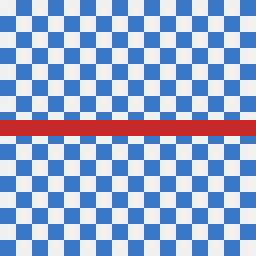

ECB 加密后图像:


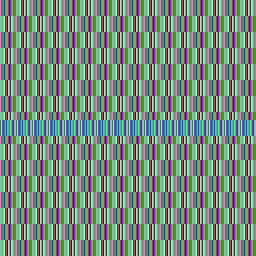

CBC 加密后图像:


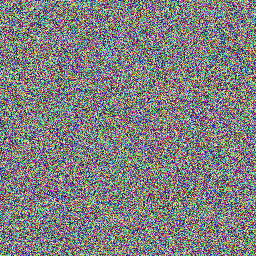

In [14]:
# 内联展示原图与加密后图像 (方便在 Notebook 中直接查看)
from IPython.display import display
from PIL import Image

orig = Image.open('orig_pattern.png')
ecb_enc = Image.open('ecb_encrypted.png')
cbc_enc = Image.open('cbc_encrypted.png')

print('原始图:')
display(orig)
print('ECB 加密后图像:')
display(ecb_enc)
print('CBC 加密后图像:')
display(cbc_enc)
